In [ ]:
#importando librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files

In [ ]:
# 1. Subir archivos de contaminantes (pueden ser varios)
print("Sube los archivos contaminantes_<año>.csv (uno o varios)")
uploaded_pollution = files.upload()

Sube los archivos contaminantes_<año>.csv (uno o varios)


Saving contaminantes_2022.csv to contaminantes_2022 (2).csv
Saving contaminantes_2023.csv to contaminantes_2023 (2).csv


In [ ]:
# concatenar archivos de contaminantes
pollution_dfs = []
for name, content in uploaded_pollution.items():
    df = pd.read_csv(io.StringIO(content.decode("utf-8")))
    # Eliminar columna ESTACION si existe
    df = df.drop(columns=["ESTACION"], errors="ignore")
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.groupby("time", as_index=False).mean(numeric_only=True)  # Promediar por hora
    pollution_dfs.append(df)

pollution_data = pd.concat(pollution_dfs, ignore_index=True)

In [ ]:
# 2. Subir archivo meteorológico (uno solo)
print("Sube el archivo de datos meteorológicos (formato: time, temp, ..., station)")
uploaded_weather = files.upload()

Sube el archivo de datos meteorológicos (formato: time, temp, ..., station)


Saving datos_madrid_2022_2023_meteostat.csv to datos_madrid_2022_2023_meteostat (1).csv


In [ ]:
weather_filename = next(iter(uploaded_weather))
weather_data = pd.read_csv(io.StringIO(uploaded_weather[weather_filename].decode("utf-8")))

/tmp/ipython-input-5-1174450584.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(io.StringIO(uploaded_weather[weather_filename].decode("utf-8")))


In [ ]:
# Convertir columna time a datetime
weather_data["time"] = pd.to_datetime(weather_data["time"], errors="coerce")
# Eliminar columna station si existe
weather_data = weather_data.drop(columns=["station"], errors="ignore")

# Agrupar por hora y calcular promedio de todas las variables meteorológicas
weather_avg = weather_data.groupby("time", as_index=False).mean(numeric_only=True)

In [ ]:
# Unir ambos datasets por columna time
final_data = pd.merge(pollution_data, weather_avg, on="time", how="inner")
final_data.head()

,time,CO,NO2,O3,PM10,PM25,SO2,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2022-01-01 00:00:00,0.500000,41.173913,8.781538,37.272727,35.625,4.000000,5.525,4.200,91.0,0.0,NaN,99.75,6.925,NaN,1030.250,NaN,1.0
1,2022-01-01 01:00:00,0.466667,37.565217,9.619231,30.000000,28.125,4.000000,4.850,3.650,92.0,0.0,NaN,11.75,4.150,NaN,1029.900,NaN,1.0
2,2022-01-01 02:00:00,0.433333,32.565217,10.962308,21.923077,19.250,4.000000,4.300,3.200,92.5,0.0,NaN,171.75,4.775,NaN,1029.875,NaN,1.0
3,2022-01-01 03:00:00,0.400000,25.608696,13.469231,15.923077,13.750,3.333333,4.250,2.650,89.5,0.0,NaN,96.50,7.125,NaN,1029.800,NaN,1.0
4,2022-01-01 04:00:00,0.300000,23.782609,14.371538,15.769231,14.500,3.000000,3.225,1.325,87.5,0.0,NaN,104.75,6.025,NaN,1030.250,NaN,1.0


In [ ]:
# eliminamos la variable 'coco', debido a que se trata de una codificación que usa la app de meteostat
final_data = final_data.drop(columns="coco")

In [ ]:
# Verificar si hay filas duplicadas en la columna 'time'
duplicated_times = final_data[final_data.duplicated(subset=["time"], keep=False)]

# Mostrar resultados
if not duplicated_times.empty:
    print("Filas duplicadas encontradas en 'time':")
    display(duplicated_times.sort_values("time"))
else:
    print("No se encontraron duplicados en la columna 'time'.")

No se encontraron duplicados en la columna 'time'.


In [ ]:
def calcular_porcentaje_nulos(df):
    """
    Devuelve un DataFrame con el número y porcentaje de valores nulos por variable.
    """
    resultados = []
    # Recorremos todas las columnas menos 'time'
    for col in df.columns.drop('time', errors='ignore'):
        total = len(df[col])
        nulos = df[col].isna().sum()
        porcentaje = (nulos / total) * 100 if total > 0 else 0
        resultados.append((col, nulos, total, round(porcentaje, 2)))

    resultados_df = (
        pd.DataFrame(resultados,
                     columns=["Variable", "Nulos", "Total valores", "% Nulos"])
          .sort_values("% Nulos", ascending=False)
          .reset_index(drop=True)
    )
    return resultados_df

# Aplicar al DataFrame final
nulos_pct_df = calcular_porcentaje_nulos(final_data)
display(nulos_pct_df)

,Variable,Nulos,Total valores,% Nulos
0,tsun,17518,17518,100.00
1,snow,16861,17518,96.25
2,wpgt,15097,17518,86.18
3,CO,2,17518,0.01
4,PM25,2,17518,0.01
5,NO2,2,17518,0.01
6,O3,2,17518,0.01
7,PM10,2,17518,0.01
8,SO2,2,17518,0.01
9,temp,0,17518,0.00


Se observan valores nulos para más del 80% de las observaciones de las variables:

| Variable | Descripción                                      |
|----------|--------------------------------------------------|
| tsun     | Total de minutos de sol en una hora             |
| snow     | Profundidad de la nieve en mm                   |
| wpgt     | Ráfaga máxima de viento en km/h                 |

Esto podría deberse a que, aunque en Madrid nieva muy poco (snow), es posible que los datos simplemente no se hayan registrado en muchas estaciones urbanas, y no necesariamente a que nunca ocurra. Además, la radiación suele reportarse solo como dato diario, y las ráfagas máximas de viento (wpgt) a menudo no se registran de forma rutinaria en estas estaciones, sino únicamente durante episodios de viento extremo, mientras que normalmente se mide solo la velocidad media (wspd).

In [ ]:
# eliminamos estas 3 variables
columns_to_drop = ['tsun', 'snow', 'wpgt']
final_data = final_data.drop(columns=[col for col in columns_to_drop if col in final_data.columns])

#renombramos PM25 por PM2.5
final_data = final_data.rename(columns={'PM25': 'PM2.5'})
final_data.head()

,time,CO,NO2,O3,PM10,PM2.5,SO2,temp,dwpt,rhum,prcp,wdir,wspd,pres
0,2022-01-01 00:00:00,0.500000,41.173913,8.781538,37.272727,35.625,4.000000,5.525,4.200,91.0,0.0,99.75,6.925,1030.250
1,2022-01-01 01:00:00,0.466667,37.565217,9.619231,30.000000,28.125,4.000000,4.850,3.650,92.0,0.0,11.75,4.150,1029.900
2,2022-01-01 02:00:00,0.433333,32.565217,10.962308,21.923077,19.250,4.000000,4.300,3.200,92.5,0.0,171.75,4.775,1029.875
3,2022-01-01 03:00:00,0.400000,25.608696,13.469231,15.923077,13.750,3.333333,4.250,2.650,89.5,0.0,96.50,7.125,1029.800
4,2022-01-01 04:00:00,0.300000,23.782609,14.371538,15.769231,14.500,3.000000,3.225,1.325,87.5,0.0,104.75,6.025,1030.250


##  Descripción de Variables a usar


| Variable | Descripción | Importancia para el modelado de PM2.5 |
|---|---|---|
| **time** | Fecha y hora de la observación (UTC). | Permite análisis temporal, creación de lags, estacionalidad y tendencias. |
| **CO (mg/m³)** | Monóxido de carbono, contaminante de combustión incompleta (tráfico, calefacción). | Correlaciona con PM2.5 como trazador de emisiones directas. |
| **NO2 (µg/m³)** | Dióxido de nitrógeno, producto del tráfico y calefacción urbana. | Relacionado con la formación de aerosoles secundarios que forman parte de PM2.5. |
| **O3 (µg/m³ o ppb)** | Ozono troposférico, contaminante secundario formado por reacciones fotoquímicas. | Suele tener relación inversa con PM2.5, especialmente en verano. |
| **PM10 (µg/m³)** | Partículas ≤ 10 µm, incluye PM2.5. | Altamente correlacionado, aporta información de polvo y emisiones gruesas. |
| **PM2.5 (µg/m³)** | Partículas ≤ 2.5 µm, **variable objetivo**. | Indicador clave de contaminación, afecta salud y visibilidad. |
| **SO2 (µg/m³)** | Dióxido de azufre, proveniente de combustibles fósiles e industria. | Contribuye a formación de sulfatos en PM2.5. |
| **temp (°C)** | Temperatura del aire. | Influye en la formación y dispersión de partículas finas. |
| **dwpt (°C)** | Punto de rocío. |  Temperatura a la que el aire debe enfriarse para que se sature con vapor de agua y se produzca condensación. |
| **rhum (%)** | Humedad relativa. | Alta humedad puede aumentar la concentración de PM2.5 por absorción de agua. |
| **prcp (mm/h)** | Precipitación por hora. | La lluvia limpia el aire reduciendo PM2.5 de forma efectiva. |
| **wdir (°)** | Dirección del viento. | Ayuda a identificar fuentes de contaminación según la procedencia del aire. |
| **wspd (m/s)** | Velocidad del viento. | Vientos fuertes dispersan contaminantes; vientos bajos permiten acumulación. |
| **pres (hPa)** | Presión atmosférica. | Alta presión favorece estabilidad y acumulación de contaminantes. |



In [ ]:
#vemos los estadísticos de nuestra dataset
final_data.describe()

,time,CO,NO2,O3,PM10,PM2.5,SO2,temp,dwpt,rhum,prcp,wdir,wspd,pres
count,17518,17516.000000,17516.000000,17516.000000,17516.000000,17516.000000,17516.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000
mean,2022-12-31 23:46:05.658180096,0.324492,27.945045,54.406589,20.021485,9.559810,3.077467,16.065979,5.890174,58.118321,0.056951,165.738165,10.521981,1018.274119
min,2022-01-01 00:00:00,0.100000,1.652174,1.216923,1.384615,1.000000,0.666667,-3.940000,-14.740000,5.600000,0.000000,3.250000,0.350000,989.980000
25%,2022-07-02 12:15:00,0.233333,13.260870,30.231346,10.461538,5.000000,2.000000,9.100000,2.500000,37.400000,0.000000,100.600000,6.120000,1013.860000
50%,2022-12-31 23:30:00,0.275000,21.956522,54.098371,16.076923,7.875000,3.000000,15.040000,6.340000,58.500000,0.000000,171.750000,8.880000,1017.560000
75%,2023-07-02 11:45:00,0.366667,37.547554,74.767115,24.769231,12.000000,4.000000,22.700000,9.700000,80.000000,0.000000,228.800000,13.640000,1022.400000
max,2023-12-31 23:00:00,1.500000,134.391304,194.538462,494.000000,84.750000,14.250000,40.780000,17.980000,100.000000,9.980000,357.000000,45.120000,1039.040000
std,NaN,0.142412,19.723919,31.179285,18.908821,6.826911,1.418520,9.201690,5.195711,24.630698,0.354322,76.967292,6.005400,6.657664


Parece que el dataset está completo y consistente, con casi todos los valores presentes y cubriendo dos años de datos horarios. Los contaminantes presentan valores en rangos urbanos típicos de Madrid, con algunos picos elevados en PM10 y PM2.5 que podrían ser outliers de eventos de contaminación o polvo. Las variables meteorológicas reflejan la estacionalidad local, con temperaturas de -4°C a 41°C, humedad promedio del 58% y muy poca precipitación, coherente con el clima de Madrid.

Se observan que tenemos dos filas con valores nules para las variables de contaminantes, ya que se tienen valores para 17.516 de 17.518 que poseen las demás variables.

Así mismo, se determina que hacen falta dos registros en nuestro dataset. Ya que si teoría tenemos 24 registros en 365 por 2 años, deberíamos tener 17520 filas y no 17518. Vamos a revisar primero estos datos registros faltantes.

In [ ]:
# Trabajamos con una copia segura de la columna 'time'
time_copy = pd.to_datetime(final_data['time'].copy())

# Generamos el rango esperado de horas para 2022 y 2023
expected_time_range = pd.date_range(start='2022-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')

# Verificamos horas faltantes
missing_hours = pd.DataFrame({'time': expected_time_range}).merge(
    pd.DataFrame({'time': time_copy}),
    on='time',
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns=['_merge'])

# Mostramos resumen
print(f"Horas faltantes: {missing_hours.shape[0]}")
print(missing_hours.head(10))


Horas faltantes: 2
                     time
2042  2022-03-27 02:00:00
10778 2023-03-26 02:00:00


/tmp/ipython-input-13-1554252043.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_time_range = pd.date_range(start='2022-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')


Durante los cambios de horario de verano en marzo, faltan horas en el dataset porque en España, al adelantar el reloj de las 02:00 a las 03:00, la hora intermedia desaparece y no se registran datos, lo cual es completamente normal en series de tiempo en hora local. Sin embargo, en octubre, cuando el horario de verano finaliza, el reloj se atrasa de las 03:00 a las 02:00, por lo que se debería repetir esa hora, pero este cambio ocurre a las 03:00, por lo que no se deberían generar huecos en las horas intermedias.

Antes de tratar estos datos, debemos revisar si se observan valores abnormales para los cambios de fin de verano de octubre 2022 y 2023 a las 2:00 AM.

In [ ]:
# Fechas de fin de verano en España (cuando se atrasa 1 hora)
october_dst_dates = ['2022-10-30', '2023-10-29']

for date in october_dst_dates:
    # Filtrar entre 01:00 y 04:00 AM para ver antes, durante y después del cambio
    start_time = pd.Timestamp(f"{date} 00:00:00")
    end_time = pd.Timestamp(f"{date} 04:00:00")

    # Filtrar registros en ese rango
    window_hours = final_data[(time_copy >= start_time) & (time_copy <= end_time)].copy()

    print(f"\n--- Valores completos entre 09:00 y 04:00 para {date} ---")
    display(window_hours.reset_index(drop=True))


--- Valores completos entre 09:00 y 04:00 para 2022-10-30 ---


,time,CO,NO2,O3,PM10,PM2.5,SO2,temp,dwpt,rhum,prcp,wdir,wspd,pres
0,2022-10-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,16.40,7.18,54.8,0.0,170.8,9.74,1019.14
1,2022-10-30 01:00:00,0.333333,40.833333,23.326923,28.692308,14.75,2.75,15.86,7.08,56.4,0.0,199.4,6.70,1019.22
2,2022-10-30 02:00:00,0.366667,26.875000,26.483077,25.846154,15.25,2.75,14.36,6.93,61.5,0.0,196.5,6.01,1019.21
3,2022-10-30 03:00:00,0.266667,26.125000,25.340769,23.000000,13.50,3.00,13.80,7.06,64.2,0.0,141.8,5.78,1019.12
4,2022-10-30 04:00:00,0.233333,22.500000,26.711538,22.846154,14.25,2.75,13.20,7.34,67.8,0.0,145.2,6.06,1018.72



--- Valores completos entre 09:00 y 04:00 para 2023-10-29 ---


,time,CO,NO2,O3,PM10,PM2.5,SO2,temp,dwpt,rhum,prcp,wdir,wspd,pres
0,2023-10-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,14.02,11.26,83.4,0.00,201.6,18.24,1009.08
1,2023-10-29 01:00:00,0.200000,9.478261,56.333333,9.384615,5.375,2.333333,13.50,11.68,88.8,0.22,213.6,16.72,1008.96
2,2023-10-29 02:00:00,0.166667,4.608696,65.583333,10.076923,5.125,2.000000,13.42,11.63,88.9,0.05,192.8,18.32,1008.65
3,2023-10-29 03:00:00,0.166667,3.782609,68.500000,8.923077,4.750,2.000000,13.28,11.18,87.2,0.00,193.6,18.02,1008.12
4,2023-10-29 04:00:00,0.166667,4.695652,66.000000,8.461538,4.000,2.000000,13.30,11.10,86.6,0.00,198.8,19.30,1007.86


Cabe destacar que el registro repetido que deberíamos ver en octubre durante el cambio de horario de verano no aparece en nuestro dataframe. Es posible que las estaciones meteorológicas estén configuradas para no guardar datos en la hora repetida o consoliden automáticamente los registros para evitar duplicidades.

En paralelo, hemos ya descubierta los registros con valores nulos para las variables de contaminantes que hemos identificado anteriormente, los cuales se observan  medianoche (00:00) en octubre para los días de cambio de horario durante fin de verano. Sin embargo, estos no están relacionados con el cambio de horario de fin de verano, ya que este ocurre tres horas después, y los sensores meteorológicos siguieron reportando datos en esa hora mientras que los sensores de contaminantes no lo hicieron. Esto indica que la falta de datos en CO, NO2, O3 y otros contaminantes a medianoche se debe probablemente a interrupciones de medición o mantenimiento de los sensores, no al cambio horario, y debemos imputarlos para el entrenamiento de nuestro modelo de predicción.

Debido a lo anterior y dado que sólo tenemos 2 registros con valores nulos y solo para 1 hora del dia en especifico en octubre, usaremos los valores de las horas pasadas para imputar estos vacíos.

In [ ]:
final_data_ffill = final_data.fillna(method='ffill')
display(final_data_ffill.loc[[7247, 15982]])

/tmp/ipython-input-15-2236025300.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_data_ffill = final_data.fillna(method='ffill')


,time,CO,NO2,O3,PM10,PM2.5,SO2,temp,dwpt,rhum,prcp,wdir,wspd,pres
7247,2022-10-30,0.4,44.625000,22.969231,26.692308,12.750,2.5,16.40,7.18,54.8,0.0,170.8,9.74,1019.14
15982,2023-10-29,0.2,10.304348,57.916667,5.076923,3.375,2.0,14.02,11.26,83.4,0.0,201.6,18.24,1009.08


Ahora para tratar los registros faltantes en los meses de Marzo durante el cambio de horario de verano, usaremos

In [ ]:
# Copia
final_data_ffill = final_data_ffill.copy()

# Fechas a insertar e imputar
for date_insert in ['2022-03-27 02:00:00', '2023-03-26 02:00:00']:
    # Fecha anterior a las 02:00
    date_prev = (pd.Timestamp(date_insert) - pd.Timedelta(days=1)).strftime('%Y-%m-%d 02:00:00')

    # Tomar valores del día anterior
    new_row = final_data_ffill[final_data_ffill['time'] == date_prev].copy()
    new_row['time'] = pd.Timestamp(date_insert)

    # Agregar al dataframe
    final_data_ffill = pd.concat([final_data_ffill, new_row], ignore_index=True)

# Ordenar y resetear índice
final_data_ffill = final_data_ffill.sort_values('time').reset_index(drop=True)

# Verificar visualmente
display(final_data_ffill[final_data_ffill['time'].isin(pd.to_datetime(['2022-03-27 02:00:00', '2023-03-26 02:00:00']))])


,time,CO,NO2,O3,PM10,PM2.5,SO2,temp,dwpt,rhum,prcp,wdir,wspd,pres
2042,2022-03-27 02:00:00,0.200,7.391304,75.706154,12.076923,6.25,4.333333,8.48,6.2,85.6,0.95,90.6,14.84,1018.24
10778,2023-03-26 02:00:00,0.225,14.826087,28.307692,7.307692,3.00,3.750000,10.12,9.5,96.0,0.00,241.4,9.66,1022.82


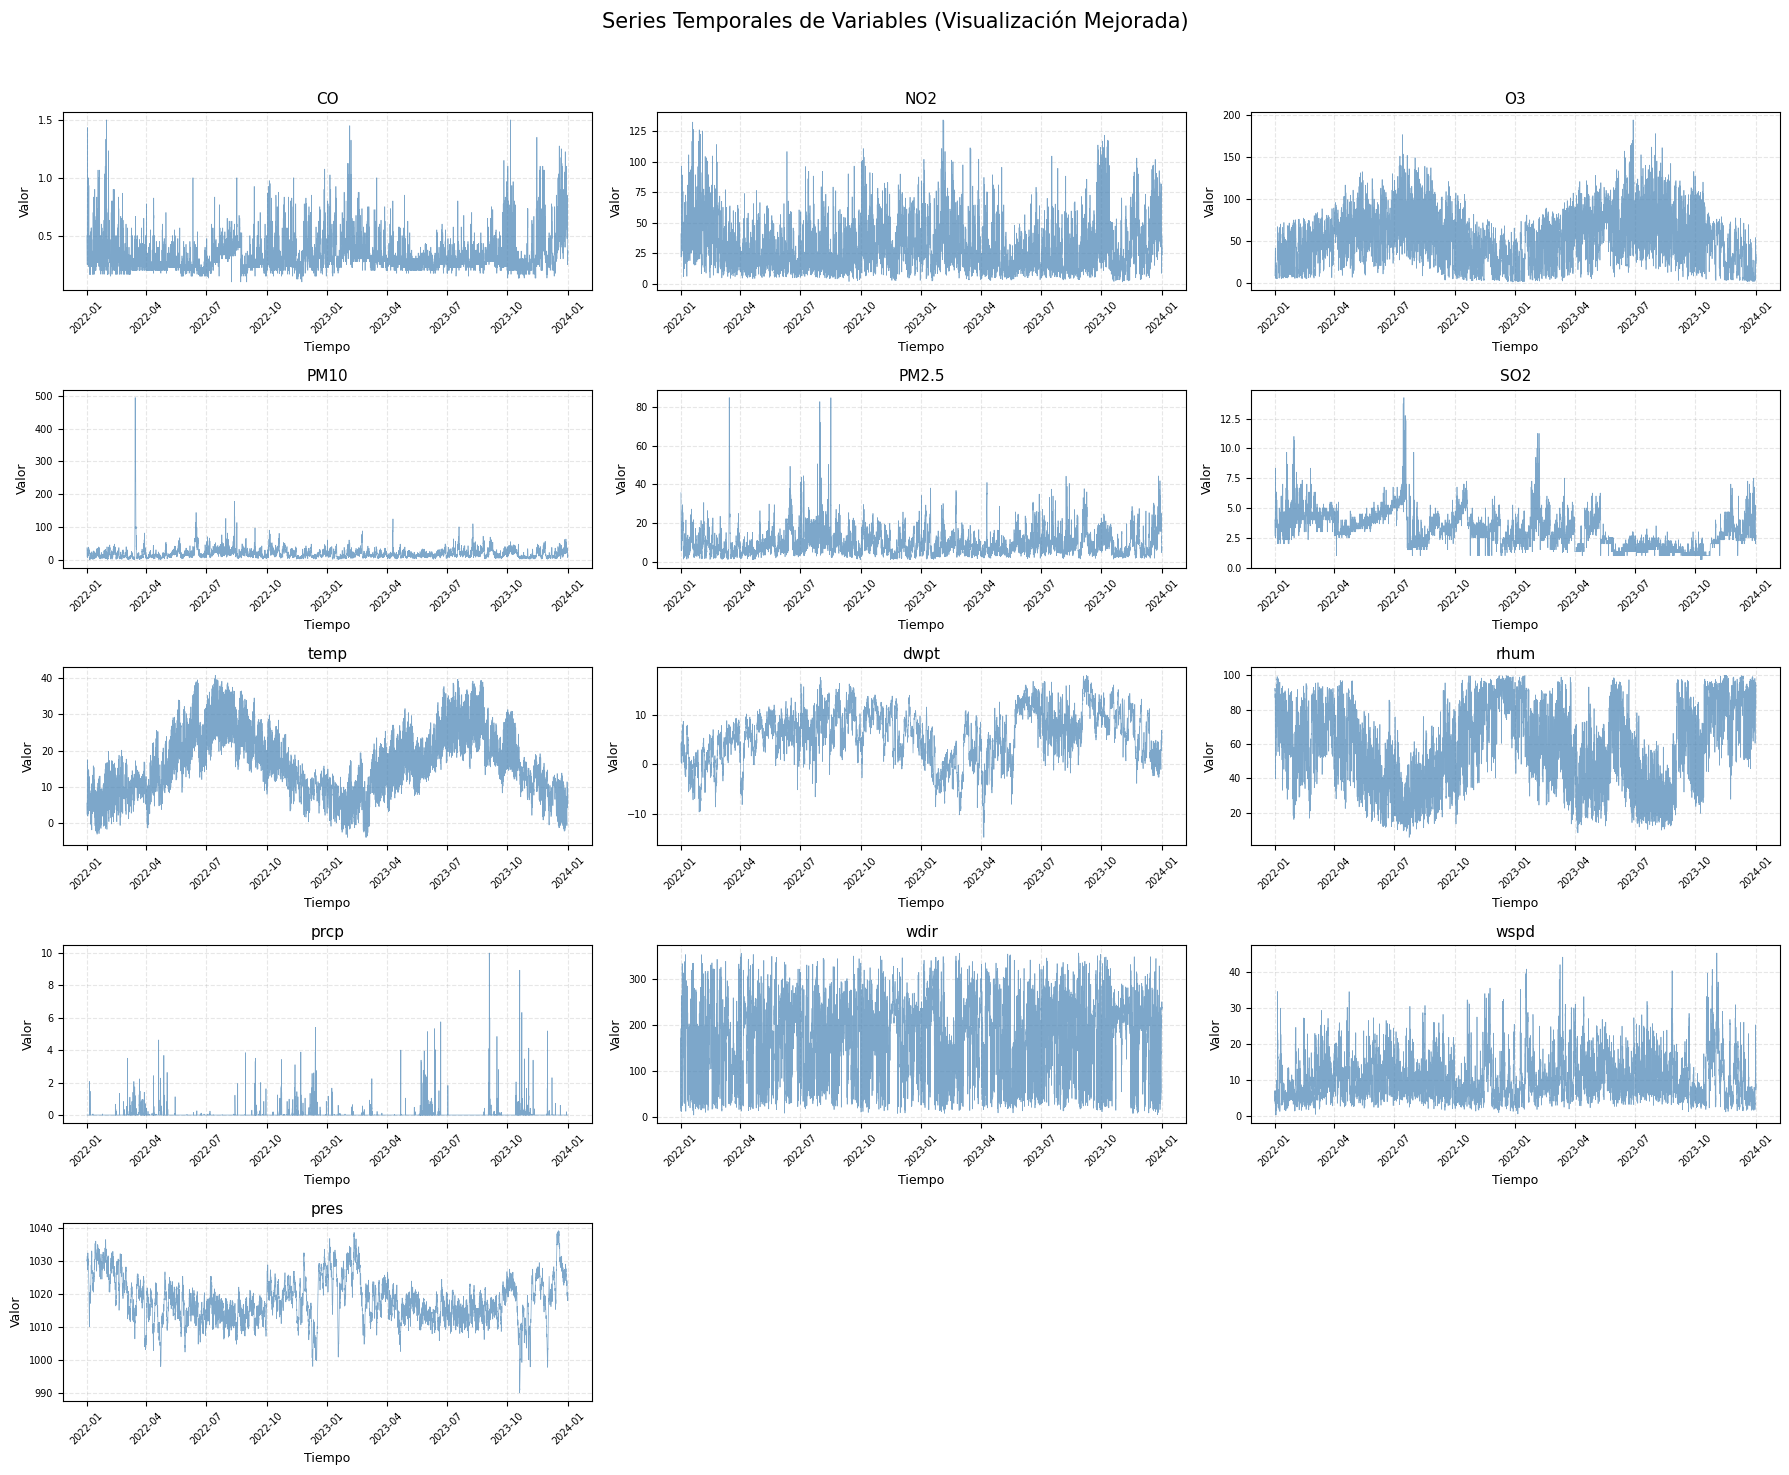

In [ ]:
def plot_series(df, time_col='time', cols=None):
    if cols is None:
        cols = [c for c in df.columns if c != time_col]

    n = len(cols)
    nc = 3
    nr = -(-n // nc)  # ceil division

    plt.figure(figsize=(nc*6, nr*3))

    for i, c in enumerate(cols, 1):
        plt.subplot(nr, nc, i)

        plt.plot(
            df[time_col], df[c],
            color='steelblue', linewidth=0.5, alpha=0.7, label=c
        )

        plt.title(c, fontsize=11)
        plt.xlabel("Tiempo", fontsize=9)
        plt.ylabel("Valor", fontsize=9)

        # Mejor legibilidad de fechas
        plt.xticks(rotation=45, fontsize=7)
        plt.yticks(fontsize=7)

        # Grilla ligera
        plt.grid(True, linestyle='--', alpha=0.3)

    plt.suptitle("Series Temporales de Variables", fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Uso:
plot_series(final_data_ffill, time_col='time')

En las variables meteorológicas (temp, dwpt, rhum, prcp, wspd, pres), se observa una marcada estacionalidad anual en temperatura y punto de rocío, con picos en verano y mínimos en invierno, mientras que la humedad relativa muestra un patrón inverso al de la temperatura. La precipitación presenta eventos puntuales de picos dispersos, indicando lluvias intensas en algunos días, y la velocidad del viento muestra fluctuaciones diarias con algunos picos claros, posiblemente ráfagas o frentes de viento. La presión atmosférica se mantiene estable con variaciones suaves, lo esperado en series largas de datos ambientales.

En las variables de contaminación (CO, NO2, O3, PM10, PM25, SO2), se observan múltiples picos a lo largo de la serie, indicando eventos de contaminación específicos. CO y NO2 muestran picos irregulares casi iguales. PM10 y PM25 presentan picos marcados en ciertos periodos, lo que puede asociarse a intrusiones de polvo o episodios de quema, y SO2, aunque en valores bajos, muestra algunos eventos aislados que podrían relacionarse con emisiones industriales.

En general, se identifica ruido de alta frecuencia en todas las variables, típico de datos horarios de contaminación y meteorología, con outliers visibles en forma de picos aislados o valores extremos.

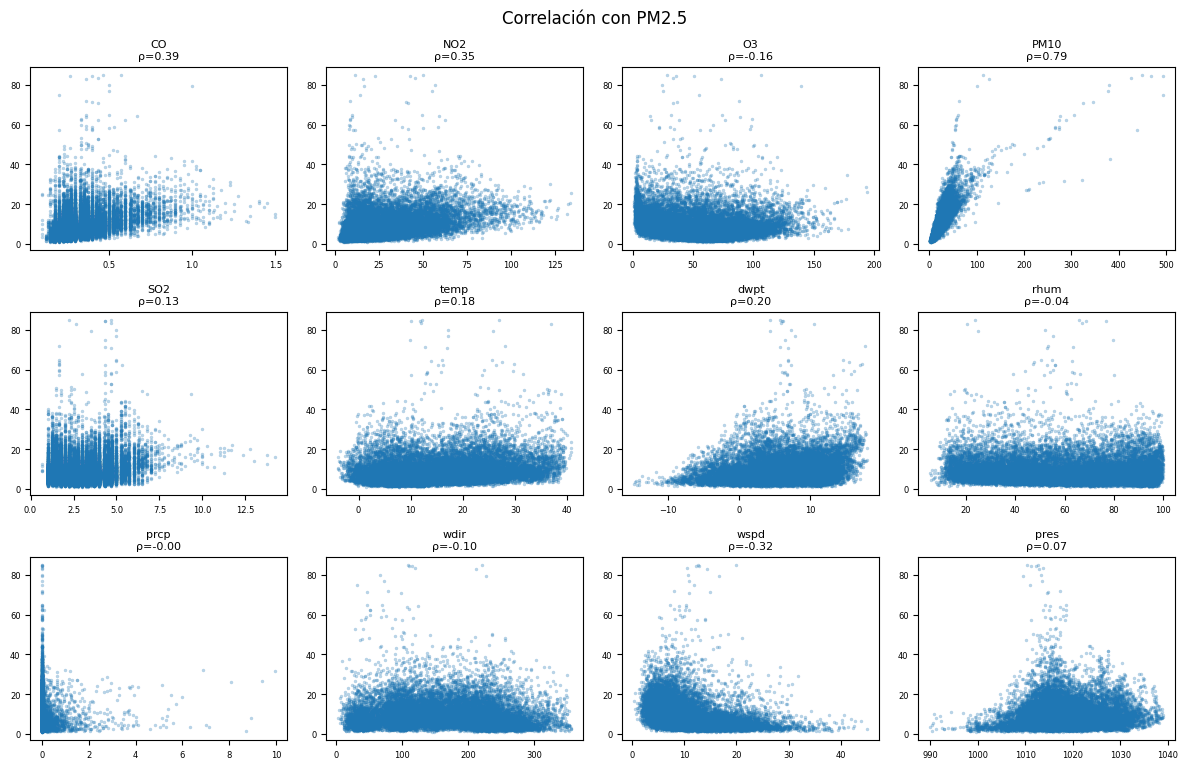

In [ ]:
def compact_correlation_grid(df, target='PM2.5', exclude_cols=['time']):
    variables = [col for col in df.columns if col not in [target] + exclude_cols]
    n = len(variables)
    nc = 4  # columnas por fila
    nr = -(-n // nc)  # filas

    plt.figure(figsize=(nc * 3, nr * 2.5))

    for i, var in enumerate(variables, 1):
        plt.subplot(nr, nc, i)
        sns.scatterplot(
            data=df, x=var, y=target,
            alpha=0.3, s=5, edgecolor=None
        )
        corr = df[[var, target]].corr().iloc[0, 1]
        plt.title(f'{var}\nρ={corr:.2f}', fontsize=8)
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.suptitle(f'Correlación con {target}', fontsize=12, y=1.02)
    plt.show()

compact_correlation_grid(final_data_ffill)

La variable PM2.5 muestra una fuerte correlación positiva con PM10 (ρ = 0.79), lo cual es esperado ya que ambas representan material particulado y suelen compartir fuentes comunes como el tráfico vehicular o la actividad industrial. También se observan correlaciones moderadas con CO (ρ = 0.39) y NO2 (ρ = 0.35), contaminantes típicamente asociados a la combustión de combustibles fósiles, lo que indica que las concentraciones de partículas finas suelen incrementarse en entornos urbanos o de alta circulación. En cambio, la velocidad del viento (wspd) muestra una correlación negativa (ρ = -0.32), sugiriendo que una mayor ventilación ayuda a dispersar los contaminantes y reducir la concentración de PM2.5.

Otras variables como la temperatura, el punto de rocío (dwpt) y el ozono (O3) presentan relaciones más débiles. Por otro lado, variables como la presión atmosférica (pres), la humedad relativa (rhum), la precipitación (prcp) y la dirección del viento (wspd) muestran correlaciones muy bajas o inexistentes con PM2.5, lo que sugiere un vínculo más indirecto o nulo en términos lineales.

In [ ]:
# mostrar % de outliers para cada variabledef calcular_pct_outliers(df):
def calcular_pct_outliers(df):
    r = []
    for c in df.select_dtypes('number').columns.drop('time', errors='ignore'):
        q1, q3 = df[c].quantile([.25, .75])
        iqr = q3 - q1
        l, u = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        t = df[c].notna().sum()
        o = ((df[c] < l) | (df[c] > u)).sum()
        r.append((c, o, t, round(o/t*100, 2) if t else 0))
    return pd.DataFrame(r, columns=["Variable", "Outliers", "Total", "% Outliers"]).sort_values("% Outliers", ascending=False)

# Uso:
outliers_pct_df = calcular_pct_outliers(final_data_ffill)
display(outliers_pct_df)

,Variable,Outliers,Total,% Outliers
9,prcp,1791,17520,10.22
0,CO,1147,17520,6.55
4,PM2.5,781,17520,4.46
3,PM10,750,17520,4.28
1,NO2,578,17520,3.30
11,wspd,484,17520,2.76
12,pres,254,17520,1.45
5,SO2,122,17520,0.70
2,O3,83,17520,0.47
7,dwpt,83,17520,0.47


Al parecer no tenemos una cantidad muy grande de outliers, lo que es un buen indicador de la calidad de nuestros datos.

A continuación revisamos visualmente los outliers a nivel de las series temporales y por medio de box plots.

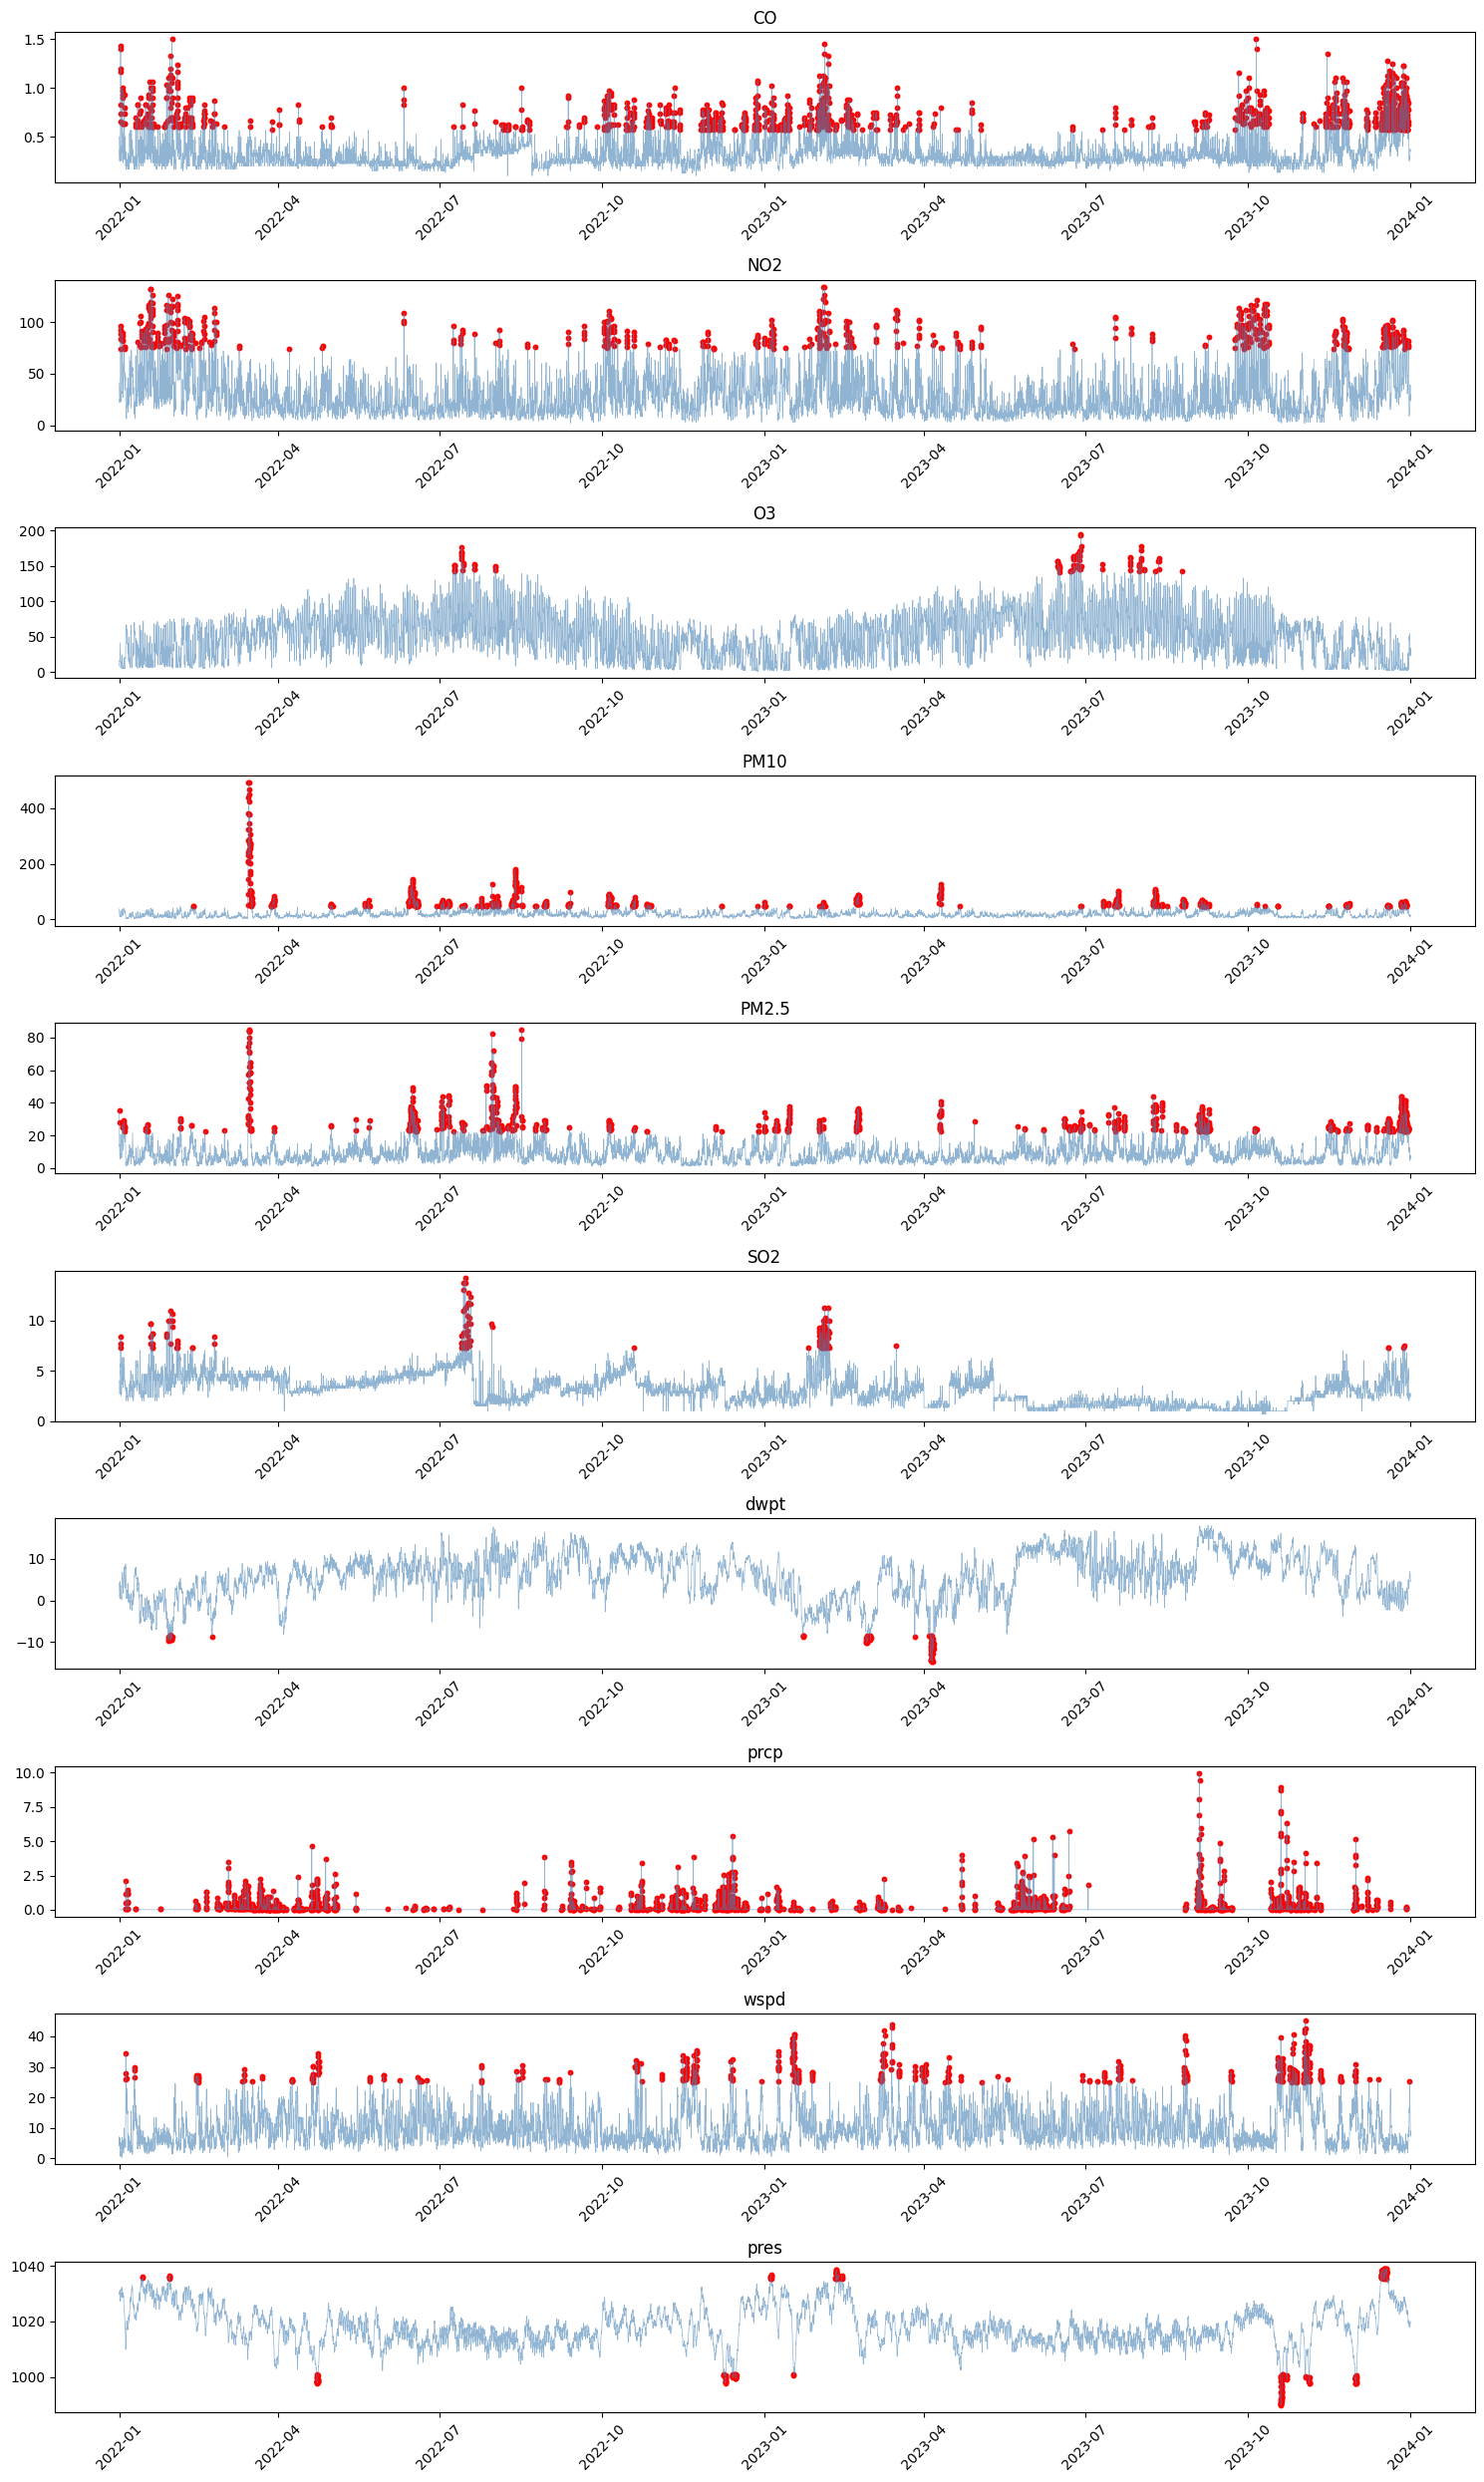

In [ ]:
def plot_series_and_outliers(df, time_col='time'):
    cols = [c for c in df.columns if c != time_col]
    outlier_cols = []

    for c in cols:
        q1, q3 = df[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        lb, ub = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        if ((df[c] < lb) | (df[c] > ub)).any():
            outlier_cols.append(c)

    plt.figure(figsize=(15, len(outlier_cols) * 2.5))

    for i, c in enumerate(outlier_cols, 1):
        q1, q3 = df[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        lb, ub = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        outliers = (df[c] < lb) | (df[c] > ub)

        plt.subplot(len(outlier_cols), 1, i)
        plt.plot(df[time_col], df[c], color='steelblue', linewidth=0.5, alpha=0.6)
        plt.scatter(df[time_col][outliers], df[c][outliers], color='red', s=10)
        plt.title(c)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_series_and_outliers(final_data_ffill, time_col='time')

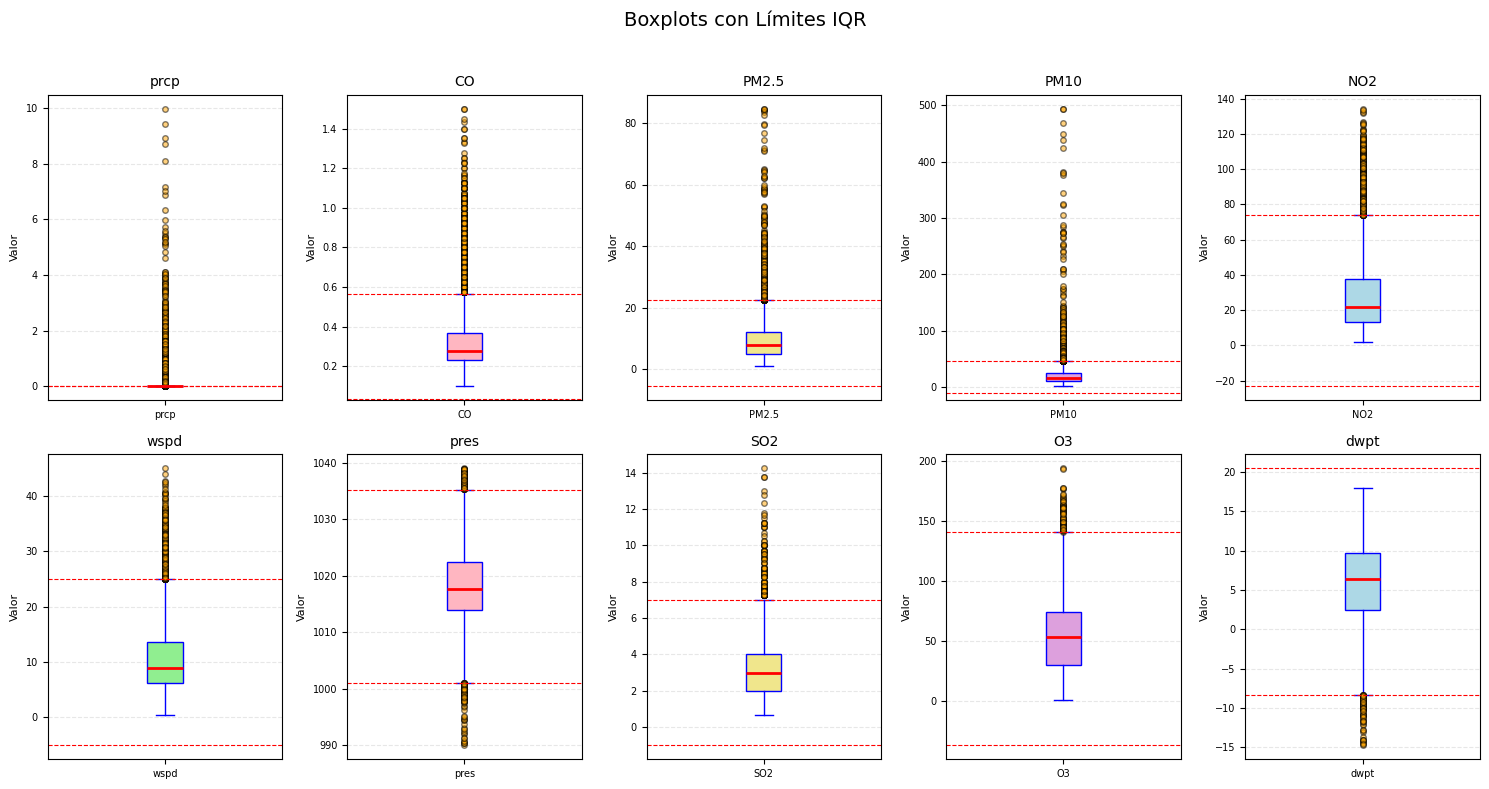

In [ ]:
def boxplots_iqr(df, cols):
    ccol = ['lightblue', 'lightgreen', 'lightpink', 'khaki', 'plum']
    n = len(cols)
    nc = 5
    nr = -(-n // nc)
    plt.figure(figsize=(nc*3, nr*4))
    for i, c in enumerate(cols, 1):
        d = df[c].dropna()
        q1, q3 = d.quantile([.25, .75])
        iqr = q3 - q1
        l, u = q1 - 1.5*iqr, q3 + 1.5*iqr
        plt.subplot(nr, nc, i)
        plt.boxplot(d, vert=True, patch_artist=True,
            boxprops=dict(facecolor=ccol[i % len(ccol)], color='blue'),
            medianprops=dict(color='red', lw=2),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(marker='o', markerfacecolor='orange', ms=4, alpha=0.5))
        plt.axhline(l, color='red', ls='--', lw=0.8)
        plt.axhline(u, color='red', ls='--', lw=0.8)
        plt.title(c, fontsize=10)
        plt.ylabel("Valor", fontsize=8)
        plt.xticks([1], [c], fontsize=7)
        plt.yticks(fontsize=7)
        plt.grid(axis='y', ls='--', alpha=0.3)
    plt.suptitle("Boxplots con Límites IQR", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

boxplots_iqr(final_data_ffill, ['prcp', 'CO', 'PM2.5', 'PM10', 'NO2', 'wspd', 'pres', 'SO2', 'O3', 'dwpt'])

De nuestras visualizaciones anteriores y a través de un análisis detallado para cada variable, se tienen las siguientes conclusiones respecto al tratamiento de los datos:

**Variables que no necesitan tratamiento**

- prcp: La precipitación presenta un comportamiento típico: muchos ceros con picos altos bien detectados como outliers. Esto refleja eventos reales de lluvia intensa. Cortar esto puede eliminar información útil.

- wspd: La velocidad del viento presenta picos constantesentre 25 m/s y 40 m/s que pueden deberse a eventos de viento fuerte (tormentas) y que deben ser considerados en el modelado.

- pres: La presión atmosférica muestra valores bastante estables, con solo unos pocos picos detectados como outliers que pueden debersea comportamiento normales de anticiclón o ciclón extratopical.

 En particular, se observa un valor máximo anómalo a finales de octubre de 2023. Este comportamiento coincide temporalmente con el paso de la borrasca Aline, un sistema profundo que afectó la península ibérica en esa fecha. Según la Agencia Estatal de Meteorología (AEMET), este evento causó intensas precipitaciones y vientos fuertes en muchas zonas, lo que puede justificar las fluctuaciones observadas en la presión. https://www.aemet.es/en/conocermas/borrascas/2023-2024/estudios_e_impactos/aline Debido a que los outliers en este período están ligados a una condición atmosférica real y relevante, no deberían ser tratados.

- O3: El ozono troposférico tiene un patrón estacional claro, con outliers en el verano. Esto es normal, ya que durante el verano la radiación solar es mas intensa y hay presencia de temperaturaes más altas, lo que acelera las reacciones fotoquímicas y favorecen  a la formación de este contaminante.

- dwp: La temperatura de punto de rocío presenta pocos outliers,siguiendo un patrón estacional entre enero y abril. Es normal que este baje durante esta época.

  Cabe destacar, que para abril del 2023 el AEMET confirmó que abril de 2023 fue el mes más cálido y seco desde 1961, con precipitaciones muy por debajo de promedio y temperaturas por encima de lo habitual. https://apnews.com/article/spain-climate-drought-rain-farmers-ccc7426e4fdf8d00ad0436868f83ed88?utm_source=chatgpt.com Debido a que los outliers en este período están ligados a una condición atmosférica real y relevante, no deberían ser tratados.

- temp, rhum,wdir: La temperatura, la humedad relativa y la velocidad del viento no poseen outliers.


**Variables que necesitan tratamiento**

- CO y NO2: El Monóxido de Carbono y el Dióxido de Azufre muestran una distribución de outliers bastante dispersa, muy similar entre ellas y recurrente, lo cual puede indicar contaminación por fuentes puntuales o errores de medición frecuentes.

- PM2.5 y PM10: Las partículas finas 2.5 y 10 también muestran una distribución de outliers bastante dispersa, muy similar entre ellas y recurrente. Por lo que deben también tratarse.

- SO2: Se observan picos bien localizados que no siguen algún patrón ni proveen algún indicio de la razón de los mismos, por lo que deben ser tratados.

# Revisamos la correlación de cada variable antes de tratar outliers

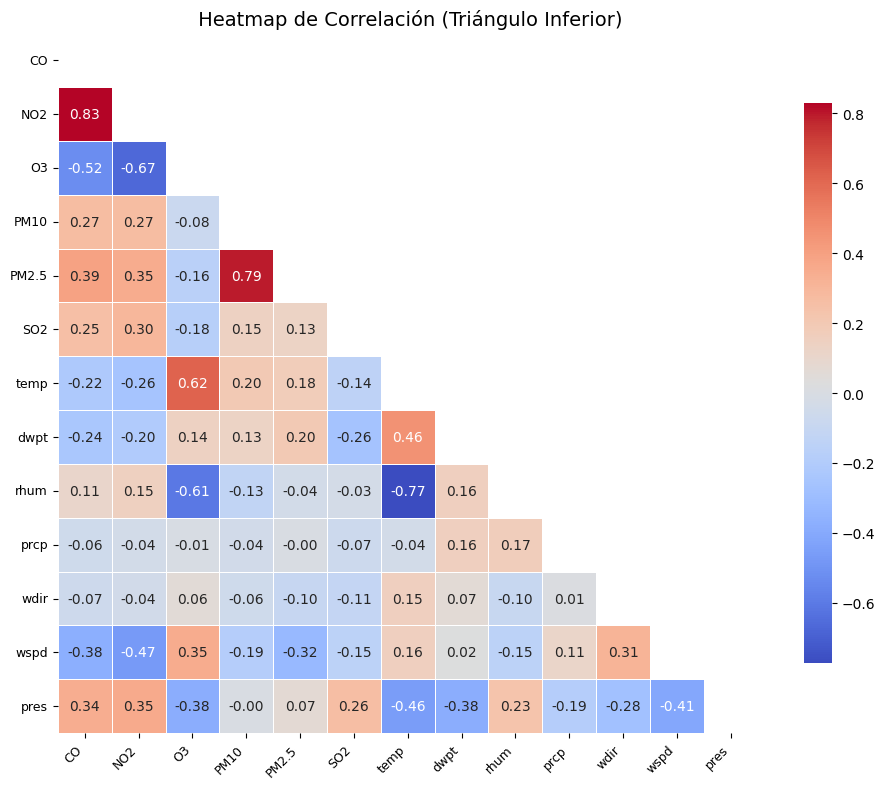

In [ ]:
# Crear Heatmap de correlación
def plot_corr_heatmap(df, drop_cols=['time']):
    corr = df.select_dtypes('number').drop(columns=drop_cols, errors='ignore').corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
                linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
    plt.title(" Heatmap de Correlación (Triángulo Inferior)", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()

# Mostrar Matrix de Correlación
plot_corr_heatmap(final_data_ffill)

Procedemos a tratar nuestras 5 variables: ['CO', 'PM2.5', 'PM10', 'NO2', 'SO2'], para esto utilizaremos mediana móvil para suavizar sin perder estructura local.

Usaremos con window = 7, lo que nos permite eliminar outliers puntuales sin deformar la serie.

In [ ]:
# Definir variables a tratar
variables_with_outliers = ['CO', 'PM2.5', 'PM10', 'NO2', 'SO2']

# Función de tratamiento para los outliers
def impute_outliers(df, cols, factor=1.5, window=7):
    df_imputed = df.copy()
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr

        # Calcular mediana móvil (rolling median)
        rolling_median = df[col].rolling(window=window, center=True, min_periods=1).median()

        mask_outlier = (df[col] < lower) | (df[col] > upper)
        n_outliers = mask_outlier.sum()

        df_imputed.loc[mask_outlier, col] = rolling_median[mask_outlier]
        print(f"{col}: {n_outliers} outliers reemplazados por mediana móvil (window={window}).")

    return df_imputed

# Crear copia y aplicar tratamiento
final_data_no_outliers = impute_outliers(final_data_ffill, variables_with_outliers)

CO: 1147 outliers reemplazados por mediana móvil (window=7).
PM2.5: 781 outliers reemplazados por mediana móvil (window=7).
PM10: 750 outliers reemplazados por mediana móvil (window=7).
NO2: 578 outliers reemplazados por mediana móvil (window=7).
SO2: 122 outliers reemplazados por mediana móvil (window=7).


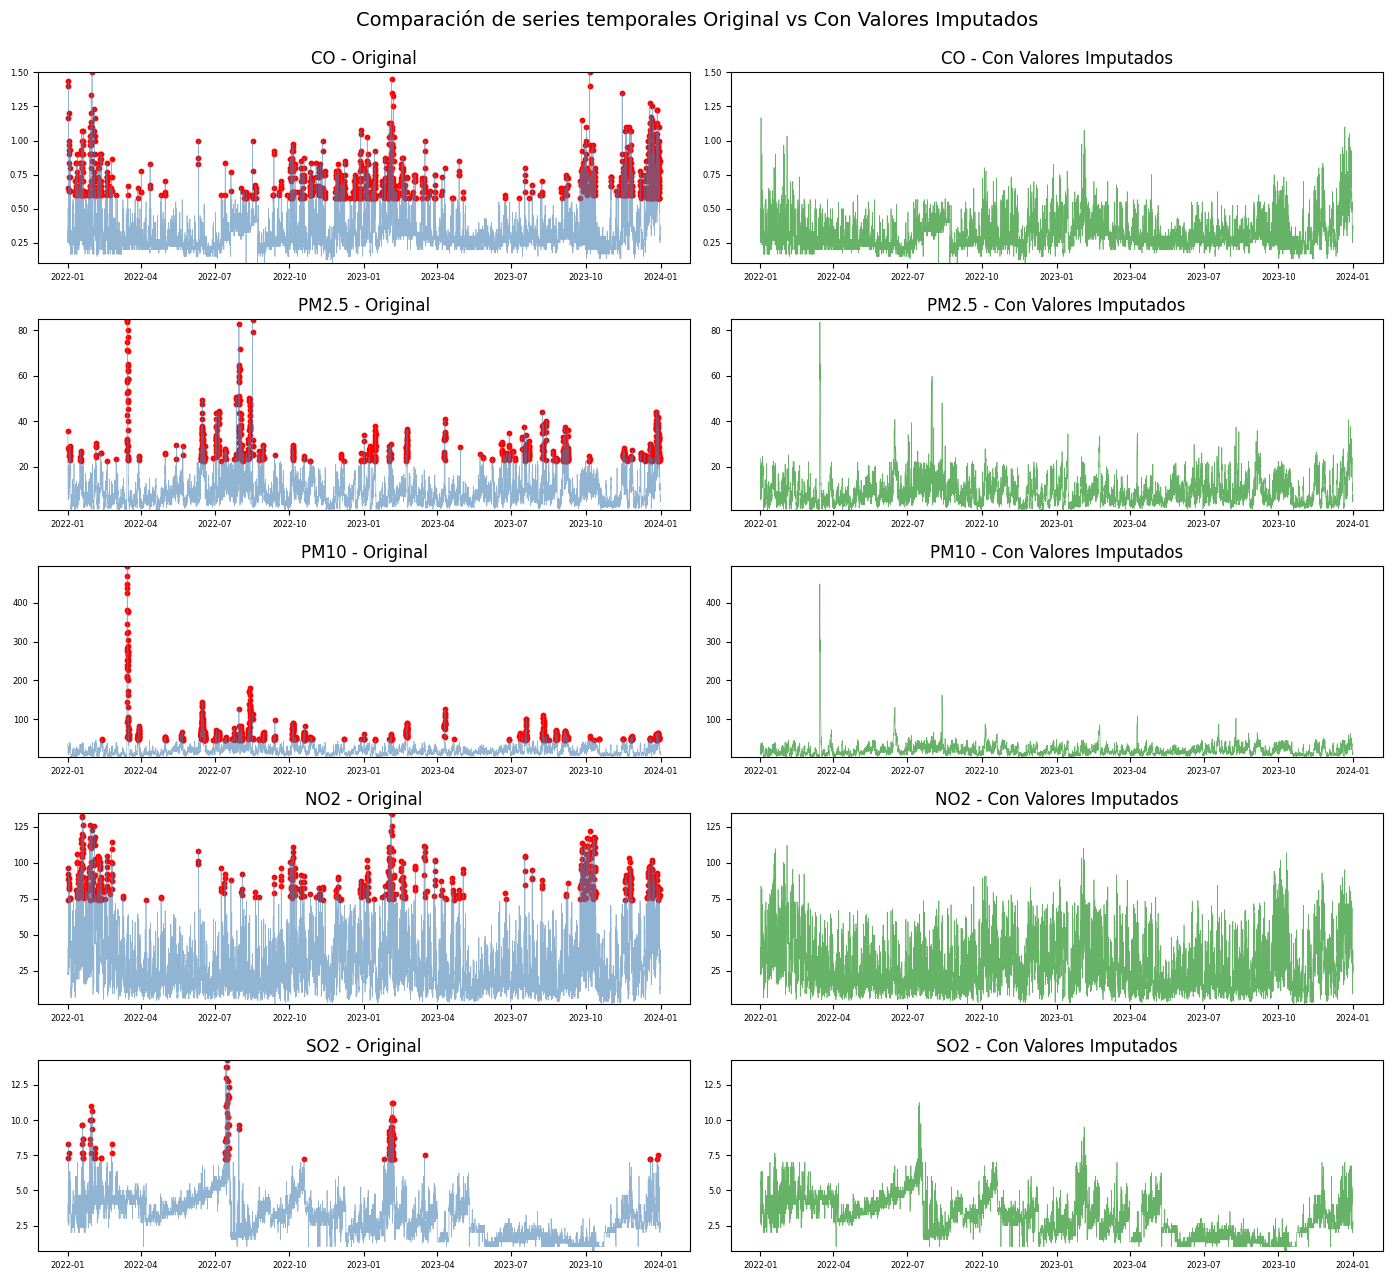

In [ ]:
def compare_time_series_with_outliers(df1, df2, variables, time_col='time', label1='Original', label2='Imputed', factor=1.5):
    import matplotlib.pyplot as plt

    n_rows = len(variables)
    plt.figure(figsize=(14, n_rows * 2.5))

    for i, var in enumerate(variables):
        # IQR para outliers
        q1 = df1[var].quantile(0.25)
        q3 = df1[var].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        outliers = (df1[var] < lower) | (df1[var] > upper)

        # Escala común
        ymin = min(df1[var].min(), df2[var].min())
        ymax = max(df1[var].max(), df2[var].max())

        # Gráfico izquierdo: original con outliers en rojo
        plt.subplot(n_rows, 2, 2*i + 1)
        plt.plot(df1[time_col], df1[var], color='steelblue', linewidth=0.5, alpha=0.6)
        plt.scatter(df1[time_col][outliers], df1[var][outliers], color='red', s=10)
        plt.title(f'{var} - {label1}')
        plt.ylim(ymin, ymax)
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)

        # Gráfico derecho: imputado
        plt.subplot(n_rows, 2, 2*i + 2)
        plt.plot(df2[time_col], df2[var], color='green', linewidth=0.5, alpha=0.6)
        plt.title(f'{var} - {label2}')
        plt.ylim(ymin, ymax)
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)

    plt.tight_layout()
    plt.suptitle(f"Comparación de series temporales {label1} vs {label2}", fontsize=14, y=1.02)
    plt.show()

# Ejecutar la comparación visual
compare_time_series_with_outliers(final_data_ffill, final_data_no_outliers, variables_with_outliers, label1='Original', label2='Con Valores Imputados')

Las series ahora generadas se ven mucho más limpias y sin picos extremos, pero conservan la variabilidad local, lo cual es idueal.

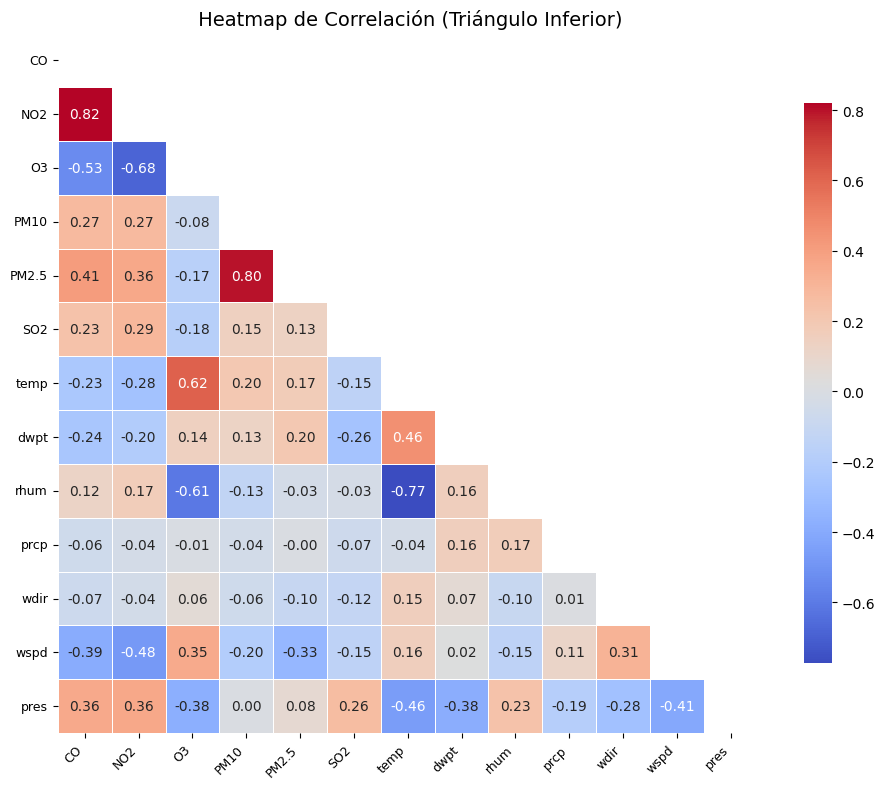

In [ ]:
# Mostrar Matriz de correlación para el dataset ahora tratado
plot_corr_heatmap(final_data_no_outliers)

Dado que CO y NO2 tiene fuerte correlacion entre ellas (0.82), tomaremos sólo la variable que tiene más correlación con la objetivo (PM2.5), la cúal sería CO.

PM10  posee relación fuerte con nuestra variable predictora PM2.5, lo que tiene sentido ya que físicamente las partículas de PM2.5 son un subconjunto de PM10 (están incluidas en PM10). Tiene sentido considerarlo en nuestro análisis.

Así mismo, si consideramos todas las variables con correlaciones leves a fuertes, es decir, inversas menores a -0.15 y las mayores a 0.15, tenemos como resultados las siguientes variables:

| Variable | Correlación con PM2.5 |
|----------|--------------------------|
| **PM10** | +0.80                    |
| **CO**   | +0.41                    |
| **dwpt** | +0.20                    |
| **temp** | +0.17                    |
| **O3**   | -0.17                    |
| **wspd** | -0.33                    |


Estas variables facilitarán capturar patrones relevantes de contaminación en el modelo SARIMAX sin incluir variables irrelevantes o redundantes.

In [ ]:
cols = ['time','PM2.5', 'PM10', 'CO', 'O3', 'wspd', 'temp', 'dwpt']
df_cleaned = final_data_no_outliers[cols]

In [ ]:
# Guardar y descargar archivo final
df_cleaned.to_csv("dataset_tratado_contaminantes_meteorologicos.csv", index=False)
files.download("dataset_tratado_contaminantes_meteorologicos.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>